In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Main Folder Path
folder_path = "/kaggle/input/kermany2018/OCT2017 "

# Sub Folder Paths
train_dir = f"{folder_path}/train"
val_dir = f"{folder_path}/val"
test_dir = f"{folder_path}/test"

In [4]:
os.listdir(folder_path)

['val', 'test', 'train']

In [5]:
print(f"Train Directory: {os.listdir(train_dir)}")
print(f"Validation Directory: {os.listdir(test_dir)}")
print(f"Test Directory: {os.listdir(val_dir)}")

Train Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Validation Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Test Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [6]:
normal_train_dir = os.path.join(train_dir, "NORMAL")
normal_train_files = os.listdir(normal_train_dir)[:30]

normal_train_files

['NORMAL-2348959-1.jpeg',
 'NORMAL-6581418-5.jpeg',
 'NORMAL-4969570-7.jpeg',
 'NORMAL-8027454-24.jpeg',
 'NORMAL-4034545-3.jpeg',
 'NORMAL-4949902-8.jpeg',
 'NORMAL-5587871-6.jpeg',
 'NORMAL-1149596-1.jpeg',
 'NORMAL-4670089-8.jpeg',
 'NORMAL-5628931-6.jpeg',
 'NORMAL-7984958-6.jpeg',
 'NORMAL-6580495-13.jpeg',
 'NORMAL-4538057-20.jpeg',
 'NORMAL-867217-3.jpeg',
 'NORMAL-9546378-10.jpeg',
 'NORMAL-9453622-6.jpeg',
 'NORMAL-3863241-1.jpeg',
 'NORMAL-8869683-18.jpeg',
 'NORMAL-114740-1.jpeg',
 'NORMAL-2483932-5.jpeg',
 'NORMAL-5535997-2.jpeg',
 'NORMAL-450923-19.jpeg',
 'NORMAL-66861-2.jpeg',
 'NORMAL-33350-20.jpeg',
 'NORMAL-519372-3.jpeg',
 'NORMAL-452201-5.jpeg',
 'NORMAL-9305707-5.jpeg',
 'NORMAL-3049062-6.jpeg',
 'NORMAL-9409941-4.jpeg',
 'NORMAL-2105194-36.jpeg']

## Baseline Model 1 — Custom CNN (grayscale 256×256)
We’ll verify a few images, build grayscale generators, define a compact CNN,
train with strong regularization, and evaluate on the test split.


Path: /kaggle/input/kermany2018/OCT2017 /train/NORMAL/NORMAL-5547799-4.jpeg
PIL mode: L  Shape: (496, 512)


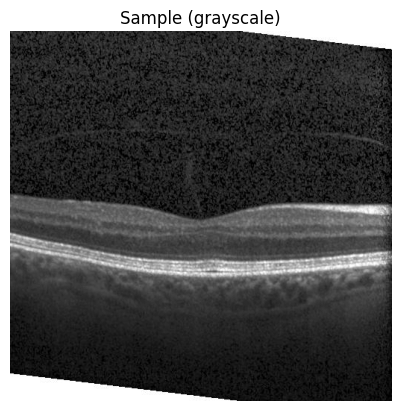

In [9]:
import random, os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

random.seed(42)

# Pick a random NORMAL image (change class to inspect others)
one_path = os.path.join(train_dir, "NORMAL", random.choice(os.listdir(os.path.join(train_dir, "NORMAL"))))
img = Image.open(one_path).convert("L")     # force grayscale
arr = np.array(img)
print("Path:", one_path)
print("PIL mode:", img.mode, " Shape:", arr.shape)

plt.imshow(arr, cmap="gray")
plt.axis("off")
plt.title("Sample (grayscale)")
plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE   = (256, 256)     # matches your earlier setup

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest",
)

eval_gen = ImageDataGenerator(rescale=1./255)

train_image_gen = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_image_gen = eval_gen.flow_from_directory(
    val_dir,                        # use "val" split for validation
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

test_image_gen = eval_gen.flow_from_directory(
    test_dir,                       # held-out test
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

num_classes = train_image_gen.num_classes
class_indices = train_image_gen.class_indices
print("Class indices:", class_indices)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Class indices: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [11]:
import os, numpy as np

cls2idx = train_image_gen.class_indices
counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in cls2idx}
total = sum(counts.values())
class_weights = {cls2idx[c]: total/(len(cls2idx)*counts[c]) for c in cls2idx}
print("Counts:", counts)
print("Class weights:", class_weights)


Counts: {'CNV': 37205, 'DME': 11348, 'DRUSEN': 8616, 'NORMAL': 26315}
Class weights: {0: 0.5609729875016799, 1: 1.8391787099048291, 2: 2.4223537604456826, 3: 0.7931217936538096}


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

image_shape = (256, 256, 1)
L2 = regularizers.l2(1e-4)

model = models.Sequential([
    layers.Input(shape=image_shape),

    layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.10),

    layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.15),

    layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.20),

    layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.20),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal", kernel_regularizer=L2),
    layers.Dropout(0.30),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(1e-3),
    metrics=["accuracy"],
)

model.summary()


I0000 00:00:1763319954.265419      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,692 (1010.52 KB)

 Trainable params: 257,988 (1007.77 KB)

 Non-trainable params: 704 (2.75 KB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

ckpt_path = "cnn_baseline_best.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    CSVLogger("cnn_baseline_log.csv", append=False),
]

EPOCHS = 15
history = model.fit(
    train_image_gen,
    validation_data=val_image_gen,
    epochs=EPOCHS,
    class_weight=class_weights,    # remove this arg if you don’t want balancing
    callbacks=callbacks,
    verbose=1,
)


Epoch 1/15


I0000 00:00:1763320056.036047     116 service.cc:148] XLA service 0x792b94015dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763320056.036935     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763320056.620194     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2609 ━━━━━━━━━━━━━━━━━━━━ 8:35:43 12s/step - accuracy: 0.2500 - loss: 1.6437

I0000 00:00:1763320064.297142     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7067 - loss: 0.8781
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to cnn_baseline_best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 775s 293ms/step - accuracy: 0.7067 - loss: 0.8780 - val_accuracy: 0.9375 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 2/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8972 - loss: 0.3995
Epoch 2: val_accuracy did not improve from 0.93750
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 543s 208ms/step - accuracy: 0.8972 - loss: 0.3995 - val_accuracy: 0.9062 - val_loss: 0.2880 - learning_rate: 0.0010
Epoch 3/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9097 - loss: 0.3587
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: val_accuracy did not improve from 0.93750
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 529s 203ms/step - accuracy: 0.9097 - loss: 0.3587 - val_accuracy: 0.9062 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 4/15
2609/2609 ━━━━━━━

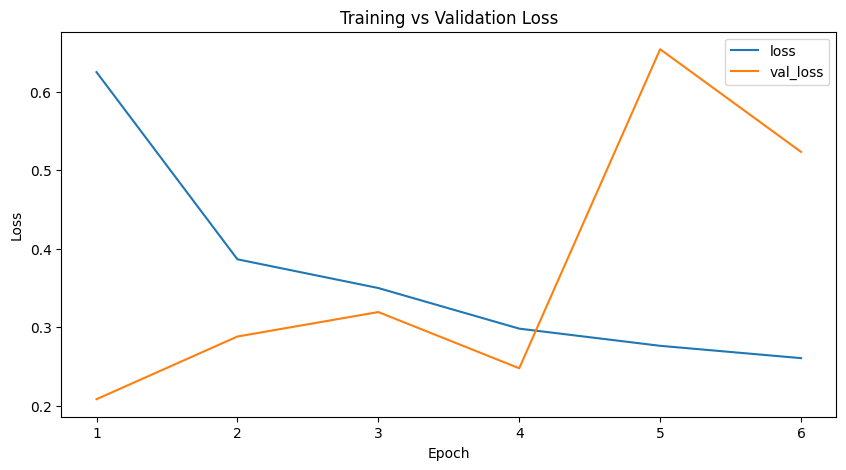

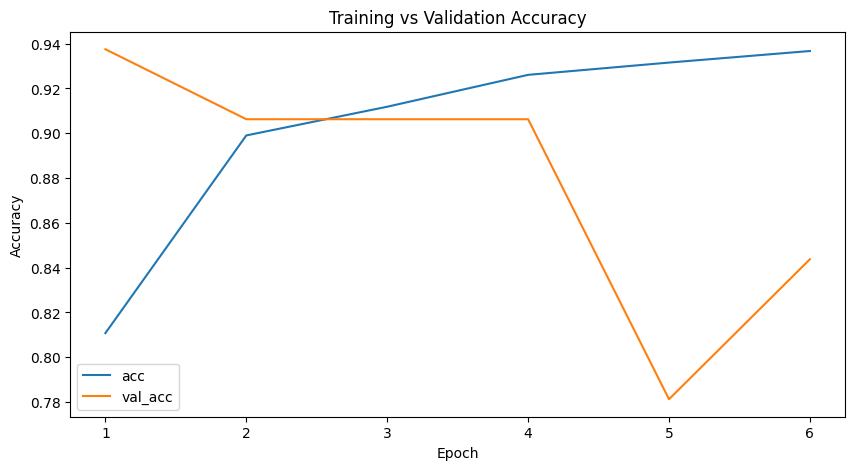

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(history.history)
hist_df.index = np.arange(1, len(hist_df)+1)

plt.figure(figsize=(10,5))
plt.plot(hist_df["loss"], label="loss")
plt.plot(hist_df["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss"); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist_df["accuracy"], label="acc")
plt.plot(hist_df["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training vs Validation Accuracy"); plt.legend(); plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.9606 - loss: 0.2101
TEST — loss: 0.2133  acc: 0.9649
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
              precision    recall  f1-score   support

         CNV     0.9203    0.9545    0.9371       242
         DME     0.9476    0.9711    0.9592       242
      DRUSEN     1.0000    0.9421    0.9702       242
      NORMAL     0.9959    0.9917    0.9938       242

    accuracy                         0.9649       968
   macro avg     0.9659    0.9649    0.9651       968
weighted avg     0.9659    0.9649    0.9651       968



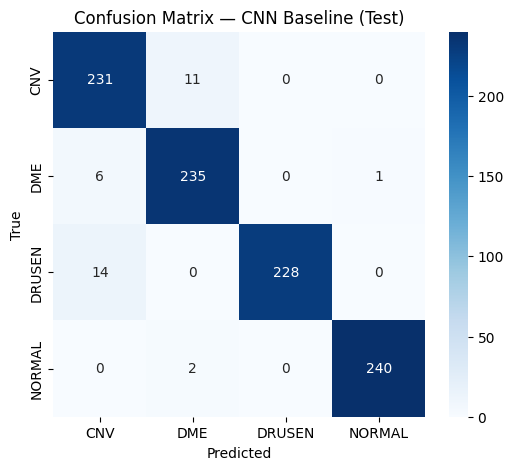

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(test_image_gen, verbose=1)
print(f"TEST — loss: {test_loss:.4f}  acc: {test_acc:.4f}")

pred_prob = model.predict(test_image_gen, verbose=1)
y_pred = pred_prob.argmax(axis=1)
y_true = test_image_gen.classes
target_names = list(test_image_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — CNN Baseline (Test)")
plt.show()


In [16]:
model.save("CNN_model1_final.keras")


## Model 2 — InceptionV3 (grayscale → RGB, 299×299)


In [25]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import (
    Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization,
    MaxPooling2D, GlobalAveragePooling2D, Input, concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

print("✅ Imports successful — TensorFlow version:", tf.__version__)


✅ Imports successful — TensorFlow version: 2.18.0


In [26]:
# Main Folder Path
folder_path = "/kaggle/input/kermany2018/OCT2017 "

# Sub Folder Paths
train_dir = f"{folder_path}/train"
val_dir = f"{folder_path}/val"
test_dir = f"{folder_path}/test"

In [27]:
os.listdir(folder_path)


['val', 'test', 'train']

In [28]:
print(f"Train Directory: {os.listdir(train_dir)}")
print(f"Validation Directory: {os.listdir(test_dir)}")
print(f"Test Directory: {os.listdir(val_dir)}")

Train Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Validation Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Test Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [29]:
# === Cell: Generators (train with aug; eval deterministic) ===
BATCH_SIZE = 32
IMG_SIZE   = (299, 299)  # InceptionV3 native

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.10,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
)

eval_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_dir, target_size=IMG_SIZE, color_mode="grayscale",
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True, seed=42
)
val_gen = eval_aug.flow_from_directory(
    val_dir, target_size=IMG_SIZE, color_mode="grayscale",
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False
)
test_gen = eval_aug.flow_from_directory(
    test_dir, target_size=IMG_SIZE, color_mode="grayscale",
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [30]:
# === Cell: Optional class weights (helps imbalance) ===
cls2idx = train_gen.class_indices
counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in cls2idx}
total = sum(counts.values())
class_weights = {cls2idx[c]: total/(num_classes*counts[c]) for c in counts}
class_weights


{0: 0.5609729875016799,
 1: 1.8391787099048291,
 2: 2.4223537604456826,
 3: 0.7931217936538096}

In [31]:
# === Cell: Build InceptionV3 (grayscale -> RGB, [-1,1] input) ===
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model, optimizers

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), name="gray_input")
x = layers.Concatenate(name="gray_to_rgb")([inputs, inputs, inputs])   # (H,W,3)
x = layers.Rescaling(scale=2.0, offset=-1.0, name="to_minus1_plus1")(x)

base = InceptionV3(weights="imagenet", include_top=False, input_tensor=x)
base.trainable = False  # Stage-1: freeze backbone

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

iv3 = Model(inputs, outputs, name="InceptionV3_OCT")
iv3.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(1e-4),
    metrics=['accuracy']
)
iv3.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "InceptionV3_OCT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gray_input          │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_to_rgb         │ (None, 299, 299,  │          0 │ gray_input[0][0], │
│ (Concatenate)       │ 3)                │            │ gray_input[0][0], │
│                     │                   │            │ gray_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ to_minus1_plus1     │ (None, 299, 299,  │          0 │ gray_to_rgb[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 149, 149,  │        864 │ to_minus1_plus1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [32]:
# === Cell: Stage-1 training (frozen backbone) ===
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

ckpt_s1 = "iv3_stage1_best.keras"
callbacks_s1 = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1),
    ModelCheckpoint(ckpt_s1, monitor="val_loss", save_best_only=True, verbose=1),
    CSVLogger("iv3_stage1_log.csv", append=False),
]

EPOCHS_1 = 10
hist_1 = iv3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_1,
    class_weight=class_weights,   # remove if you don't want weighting
    callbacks=callbacks_s1,
    verbose=1,
)


Epoch 1/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5532 - loss: 1.0918
Epoch 1: val_loss improved from inf to 0.38625, saving model to iv3_stage1_best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 705s 264ms/step - accuracy: 0.5533 - loss: 1.0918 - val_accuracy: 0.9062 - val_loss: 0.3862 - learning_rate: 1.0000e-04
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7230 - loss: 0.7675
Epoch 2: val_loss improved from 0.38625 to 0.28946, saving model to iv3_stage1_best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 708s 271ms/step - accuracy: 0.7230 - loss: 0.7675 - val_accuracy: 0.9062 - val_loss: 0.2895 - learning_rate: 1.0000e-04
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7456 - loss: 0.7104
Epoch 3: val_loss improved from 0.28946 to 0.25881, saving model to iv3_stage1_best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 711s 272ms/step - accuracy: 0.7456 - loss: 0.7104 - val_accuracy: 0.9062 - val_loss: 0.2588 - learning_rate: 1.0000e-04
Epoch 4/10


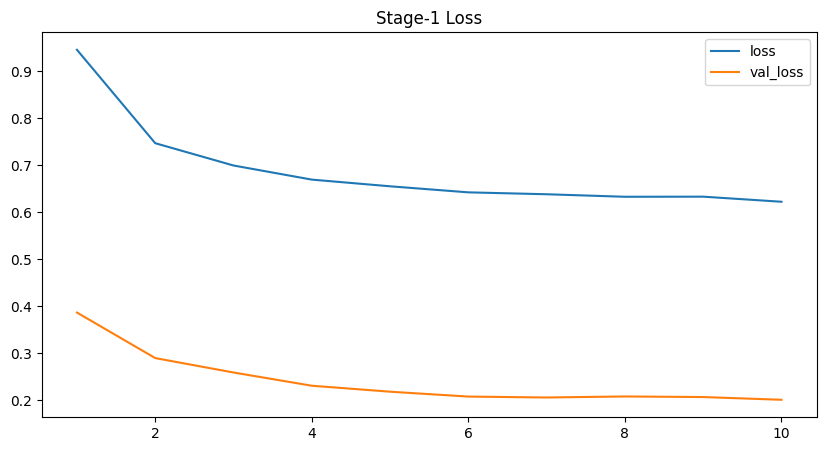

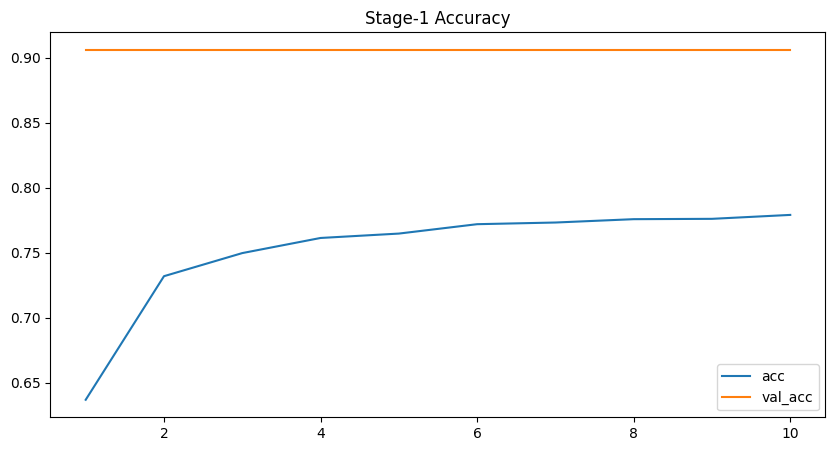

In [33]:
# === Cell: Curves for stage-1 ===
import pandas as pd, matplotlib.pyplot as plt
s1 = pd.DataFrame(hist_1.history); s1.index += 1
plt.figure(figsize=(10,5)); plt.plot(s1["loss"], label="loss"); plt.plot(s1["val_loss"], label="val_loss"); plt.legend(); plt.title("Stage-1 Loss"); plt.show()
plt.figure(figsize=(10,5)); plt.plot(s1["accuracy"], label="acc"); plt.plot(s1["val_accuracy"], label="val_acc"); plt.legend(); plt.title("Stage-1 Accuracy"); plt.show()


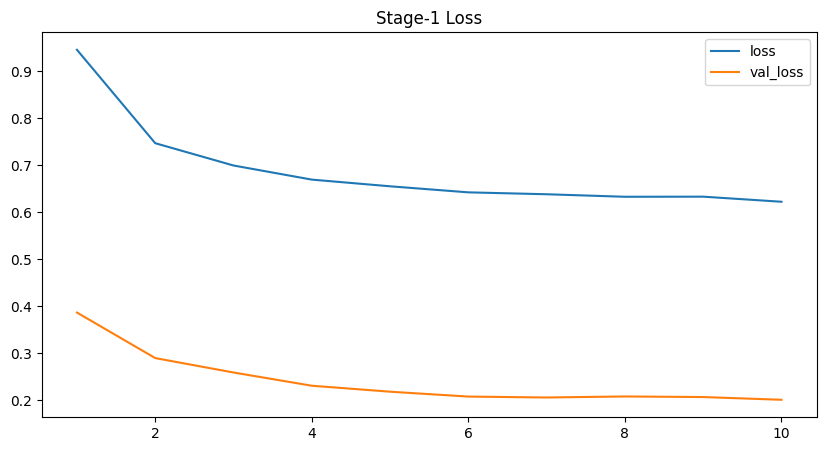

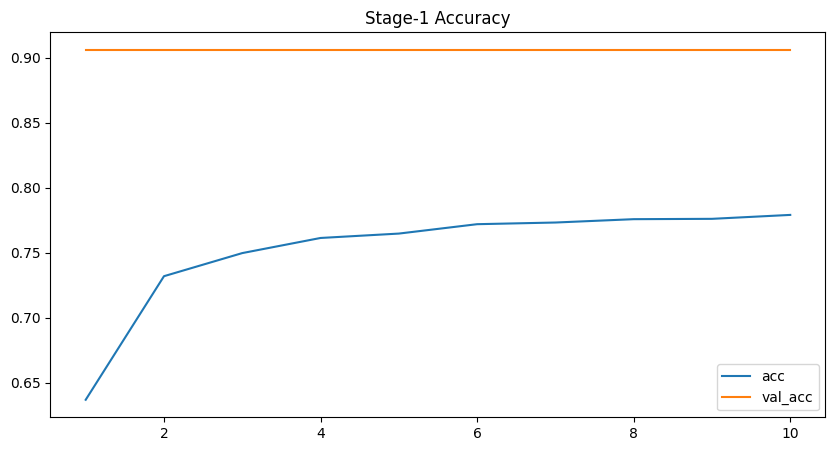

In [34]:
# === Cell: Curves for stage-1 ===
import pandas as pd, matplotlib.pyplot as plt
s1 = pd.DataFrame(hist_1.history); s1.index += 1
plt.figure(figsize=(10,5)); plt.plot(s1["loss"], label="loss"); plt.plot(s1["val_loss"], label="val_loss"); plt.legend(); plt.title("Stage-1 Loss"); plt.show()
plt.figure(figsize=(10,5)); plt.plot(s1["accuracy"], label="acc"); plt.plot(s1["val_accuracy"], label="val_acc"); plt.legend(); plt.title("Stage-1 Accuracy"); plt.show()


In [35]:
# === Cell: Stage-2 fine-tuning (unfreeze top layers, lower LR) ===
for layer in base.layers[-50:]:
    layer.trainable = True

iv3.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(1e-5),
    metrics=['accuracy']
)

ckpt_s2 = "iv3_stage2_best.keras"
callbacks_s2 = [
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1),
    ModelCheckpoint(ckpt_s2, monitor="val_loss", save_best_only=True, verbose=1),
    CSVLogger("iv3_stage2_log.csv", append=False),
]

EPOCHS_2 = 12
hist_2 = iv3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_2,
    class_weight=class_weights,
    callbacks=callbacks_s2,
    verbose=1,
)


Epoch 1/12
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7971 - loss: 0.6276
Epoch 1: val_loss improved from inf to 0.05538, saving model to iv3_stage2_best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 711s 265ms/step - accuracy: 0.7971 - loss: 0.6276 - val_accuracy: 0.9688 - val_loss: 0.0554 - learning_rate: 1.0000e-05
Epoch 2/12
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8653 - loss: 0.3883
Epoch 2: val_loss did not improve from 0.05538
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 672s 257ms/step - accuracy: 0.8653 - loss: 0.3883 - val_accuracy: 0.9688 - val_loss: 0.0579 - learning_rate: 1.0000e-05
Epoch 3/12
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8880 - loss: 0.3304
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.

Epoch 3: val_loss did not improve from 0.05538
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 691s 265ms/step - accuracy: 0.8880 - loss: 0.3304 - val_accuracy: 0.9688 - val_loss: 0.0599 - learning_rate: 1.0000e-05
Epoch 4/12
2609/260

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.9849 - loss: 0.0676
TEST — loss: 0.0820 | acc: 0.9814
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step
              precision    recall  f1-score   support

         CNV     0.9676    0.9876    0.9775       242
         DME     0.9718    0.9959    0.9837       242
      DRUSEN     0.9915    0.9587    0.9748       242
      NORMAL     0.9958    0.9835    0.9896       242

    accuracy                         0.9814       968
   macro avg     0.9817    0.9814    0.9814       968
weighted avg     0.9817    0.9814    0.9814       968



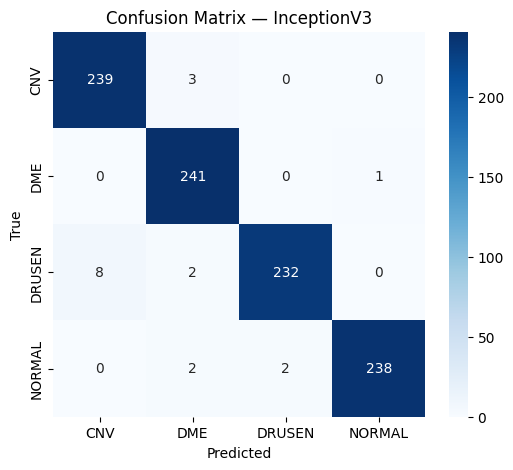

In [36]:
# === Cell: Evaluate on test + classification report + confusion matrix ===
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = iv3.evaluate(test_gen, verbose=1)
print(f"TEST — loss: {test_loss:.4f} | acc: {test_acc:.4f}")

pred_prob = iv3.predict(test_gen, verbose=1)
y_pred = pred_prob.argmax(axis=1)
y_true = test_gen.classes
target_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — InceptionV3"); plt.show()


In [37]:
# === Cell: True train accuracy (non-aug) to compare fairly with val ===
train_eval_gen = eval_aug.flow_from_directory(
    train_dir, target_size=IMG_SIZE, color_mode="grayscale",
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False
)
tr_loss, tr_acc = iv3.evaluate(train_eval_gen, verbose=1)
vl_loss, vl_acc = iv3.evaluate(val_gen, verbose=1)
print(f"Train(no-aug) acc: {tr_acc:.4f} | Val acc: {vl_acc:.4f}")


Found 83484 images belonging to 4 classes.
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 207s 79ms/step - accuracy: 0.9015 - loss: 0.2629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9688 - loss: 0.0554
Train(no-aug) acc: 0.8870 | Val acc: 0.9688
